# Assignment 2

Welcome to the second assignment! We're excited to see what you'll create using the techniques you've learned in this course.

First of all, please type your name and UID in the following format:

Firstname Lastname, #UID

In [1]:
#@title Your Info { display-mode: "form" }

Name = 'Tomasz Jezak'  #@param {type:"string"}
UID = '#105603373'  #@param {type:"string"}

### Goals
The goals of this assignment are to:

1. Build and train a convolutional neural network from scratch and using built-in PyTorch modules.
2. Build ResNet-18 from scarch and Finetune it different strategies.
3. Visualize the attention of ResNet using Class Activation Mapping
4. Come up with your own model and compete on a test leaderboard for extra credit.

By the end of this assignment, you will have gained experience with:

- Implementing and training cnns using PyTorch.
- Designing you own neural networks with the tips and tricks
- Debugging and troubleshooting issues that may arise during the development process.

Please note that it may take some time to run the entire notebook and prepare the submission version. Make sure to allocate enough time for this task and start early. If you have any questions or run into any issues, please feel free to raise them in the Piazza forum or search the internet for debugging purposes. However, please do not directly copy code from other sources.

This assignment is due on **Sunday, Feb 11th**.

**Do not use any Code AI to finish the assignment.**


Good luck and happy coding! Remember, the most important thing is to have fun and learn something new.





## Q0: Data Preparation(0 pts)

As in Assignment 1, we first download the MiniPlaces dataset and upload it to Colab using the following codes.

Note that everytime you open up this notebook, we will need to **re-download and process the dataset**. Don't worry though - this shouldn't take long, usually just a minute or less. Okay, let's get started!

To begin, you will need to download the Miniplaces Dataset from its google drive file ID.

Downloading this dataset typically takes less than 15 seconds.

In [2]:
# Downloading this file takes about a few seconds.
# Download the tar.gz file from google drive using its file ID.
!pip3 install --upgrade gdown --quiet
# unfortunately, only the following command seems to be constantly working...
!wget https://web.cs.ucla.edu/~smo3/data.tar.gz


--2024-02-15 03:14:52--  https://web.cs.ucla.edu/~smo3/data.tar.gz
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460347416 (439M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 439.02M  44.0MB/s    in 10s     

2024-02-15 03:15:02 (44.0 MB/s) - ‘data.tar.gz’ saved [460347416/460347416]



In the following code, we setup the root directory for our project, extract the dataset to the root directory, and download the label files.

In [3]:
import os

# Let's make our assignment directory
CS188_path = 'C:/TOMASZ/SOFTWARE/CS188'
os.makedirs(os.path.join(CS188_path, 'Assignment2', 'data'), exist_ok=True)
# os.makedirs will create directories recursively, i.e., it will create the
# directories and any missing parent directories if they do not exist.

# Now, let's specify the assignment path we will be working with as the root.
root_dir = os.path.join(CS188_path, 'Assignment2')

import os
import tarfile
import urllib.request

from tqdm import tqdm


def setup(file_link_dict={}):
    # Open the tar.gz file
    tar = tarfile.open("data.tar.gz", "r:gz")
    # Extract the file "./Assignment2/data" folder
    total_size = sum(f.size for f in tar.getmembers())
    with tqdm(total=total_size,
              unit="B",
              unit_scale=True,
              desc="Extracting tar.gz file") as pbar:
        for member in tar.getmembers():
            tar.extract(member, os.path.join(root_dir, 'data'))
            pbar.update(member.size)
    # Close the tar.gz file
    tar.close()

    # Next, we download the train/val/test txt files:
    for file_name, file_link in file_link_dict.items():
        print(f'Downloding {file_name}.txt from {file_link}')
        urllib.request.urlretrieve(file_link,
                                   f'{root_dir}/data/{file_name}.txt')


val_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt'
train_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt'
setup(file_link_dict={'train': train_url, 'val': val_url}, )

Extracting tar.gz file: 100%|██████████| 566M/566M [00:34<00:00, 16.2MB/s]


Downloding train.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt
Downloding val.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt


Also, it is a good habit to setup the seed before running any experiment to ensure reproducibility.

In [4]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(0)

In the following, fill in the PyTorch MiniPlaces dataset you implemented in Assignment 1(we will release the key for A1 after it's due.)
Since, we will be focused on convolutional neural networks for this assignment, **there's no need to flatten the image to a vector**. In addition, to fully utilize the modelling power of convolutional neural networks, we will not downsample the image and use its original size. Therefore, the output size of the image tensor should be $[3, 128, 128]$, please update the image transformation in the codeblock below

In [5]:
import torch
from PIL import Image
from torchvision import transforms

image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
image_net_std = torch.Tensor([0.229, 0.224, 0.225])
# Define data transformation
data_transform = transforms.Compose([
    ################# Your Implementations #####################################
    # TODO: Resize image to 128x128,
    transforms.Resize(128),
    ################# End of your Implementations ##############################
    transforms.ToTensor(),

    ################# Your Implementations #####################################
    # TODO: Normalize image using ImageNet statistics
    transforms.Normalize(mean=image_net_mean, std=image_net_std),
    ################# End of your Implementations ##############################
])

Also, we will be using the same Pytorch dataset definition in A1, just copy your implementations here:

In [6]:
import os
import pandas as pd
import re

from torch.utils.data import DataLoader, Dataset


class MiniPlaces(Dataset):

    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        # Take a second to think why we need this line.
        # Hints: training set / validation set / test set.
        self.label_dict = label_dict if label_dict is not None else {}

        # You should
        #   1. Load the train/val/test text file based on the `split` argument and
        #     store the image filenames and labels.
        #   2. Extract the class names from the image filenames and store them in
        #     self.label_dict.
        #   3. Construct a label dict that maps integer labels to class names, if
        #     the current split is "train"
        ################# Your Implementations #################################
        # Read filenames + labels from annotation files
        annotations_path = os.path.join(self.root_dir, f'{split}.txt')
        annotations = pd.read_csv(annotations_path, sep=' ', header=None)
        self.filenames = annotations.loc[:, 0]
        self.labels = annotations.loc[:, 1]

        # Create label_dict if training set
        if split == 'train':
          for i in range(0, len(self.filenames), 1000):
            label_num = self.labels[i]
            label_name = re.search(r'train\/[a-z]\/(\w+)\/.*', self.filenames[i])
            self.label_dict[label_num] = label_name.group(1) # captured label name

        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.labels)

        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)
        image = Image.open(os.path.join(self.root_dir, "images", self.filenames[idx]))
        label = self.labels[idx]
        if self.transform:
          image = self.transform(image)
        ################# End of your Implementations ##########################
        return image, label


data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces dataset object
miniplaces_train = MiniPlaces(data_root,
                              split='train',
                              transform=data_transform)

miniplaces_val = MiniPlaces(data_root,
                            split='val',
                            transform=data_transform,
                            label_dict=miniplaces_train.label_dict)

# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Create DataLoader for training and validation sets
train_loader = DataLoader(miniplaces_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(miniplaces_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)


Then, define the training and evaluation functions to train and test the CNN (Same as Assignment 1, You don't need to modify this part):

In [7]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(
            f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )


def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

Let's setting up the device, Assignment 2 involves much more computaton than Assignment 1, and hence using a GPU is preferred

In [8]:
import torch
import torch.nn.functional as F

# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [9]:
# This line of code gives you the information about GPU
! nvidia-smi

Thu Feb 15 01:31:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Q1: Convolutional Neural Network (CNN) (30 pts)

In this question, you will learn how to implement convolutional neural networks (CNNs) using PyTorch.

Similarly as Q2, we will first build a two-layer convolutional neural networks using PyTorch built-in function `nn.Conv2D` and then build the convolution operation from scratch.

### Q1.1 Fast Conv (10 pts)

Fill in the code below to implement a simple CNN similar to the MLP we built in A1, we can use built-in PyTorch Operations (e.g `nn.conv2d`) to build the network.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FastConv(nn.Module):

    def __init__(self,
                 input_channels,
                 conv_hidden_channels,
                 conv_out_channels,
                 input_size=(64, 64),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 num_classes=100,
                 kernel_size=3,
                 stride=2,
                 padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You can use Pytorch's built-in functions like, nn.Conv2d, nn.MaxPool2d, etc.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H//2, W//2)
        2) conv2: (batch_size, conv_hidden_channels, H//2, W//2) -> (batch_size, conv_out_channels, H//4, W//4)
        3) max_pooling: (batch_size, conv_out_channels, H//8, W//8)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, conv_hidden_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(conv_hidden_channels, conv_out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        self.max_pooling = nn.MaxPool2d(kernel_size=4, stride=4)  # divide dim by 4

        self.dropout1 = nn.Dropout(dropout_rate1)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc1 = nn.Linear(8*8*conv_out_channels, fc_out_channels)  # flatten_size is taken from multiplying dim's in max_pool
        self.fc2 = nn.Linear(fc_out_channels, num_classes)
        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # replace "None"s with your implementations.
        # All you need to do is to pass the input arguments to different constructors

        ################# End of your Implementations ##########################

    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        7) fc2: Pass the output from the actiction layer to through a fully connected
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network
        x = F.relu(self.conv1(x))
        x = self.max_pooling((self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.dropout2(self.fc1(x)))
        x = self.fc2(x)


        ################# End of your Implementations ##########################
        return x

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = FastConv(input_channels=3,
                 conv_hidden_channels=64,
                 conv_out_channels=128,
                 input_size=(128, 128),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 kernel_size=3,
                 stride=2,
                 padding=1,
                 num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [01:49<00:00, 14.33it/s, loss=4.02]


Validation set: Average loss = 3.5216, Accuracy = 0.1643


Epoch 2/5: 100%|██████████| 1563/1563 [01:45<00:00, 14.87it/s, loss=3.6]


Validation set: Average loss = 3.2828, Accuracy = 0.2035


Epoch 3/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.90it/s, loss=4.07]


Validation set: Average loss = 3.3012, Accuracy = 0.2061


Epoch 4/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.90it/s, loss=3.37]


Validation set: Average loss = 3.1624, Accuracy = 0.2272


Epoch 5/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.89it/s, loss=3.62]


Validation set: Average loss = 3.1422, Accuracy = 0.2270


You should get around 14.93% accuracy after the first epoch and 18.27% accuracy after five epochs, which is a huge improvement from using MLPs.

### Q1.2 Building 2D Convolutional layer from sratch (20pts)

Next, we will build convolutional neural networks from scratch.


Let's ignore channels for now and see how this works with two-dimensional data had hidden representations. In the following figure, the input is a two-dimensional tensor with hegith of 3 and width of 3. We mark the shape of the tensor as $3\times3$. The height and width of the kernel are both 2. The shape of the kernel window (or convolution window) is given by the height and width of the kernel (here it is $2\times2$).

![correlation](https://web.cs.ucla.edu/~smo3/cs188/assignment2/correlation.png)


In the two-dimensional convolution operation, we begin with the convolution window position at the upper-left corner of the input tensor and slide it across the intput tensor, both from left to right and top to bottom. When the convolution window slides to a certain position, the input subtensor contained in that window and the kernel tensor are multiplied elementwise and the resulting tensor is summed up yielding a single scalar value. This result gives the value of the output tensor at the corresponding location. Here, the output tensor has a height of 2 and width of 2 and the four elements are derived from the two-dimensional cross-correlation operation:
$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than one,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_h \times n_w$
minus the size of the convolution kernel $k_h \times k_w$
via

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.

#### Q1.2.1 One Channel Convolution (5pts)
That's start with 2D convolution with only 1 input channel and 1 kernel.
If your implementation is right, you'll get:
```
tensor([[19., 25.],
        [37., 43.]])
```

In [ ]:
def conv2d(X, K):
    """
    Compute 2D convolution. You are supposed to use matrix multiplication
    to achieve the 2D convolution instead of torch build in convolution method.

        Args:
          X (tensor): Input tensor in the shape of (n_h,n_w).
          K (tensor): Kernel tensor in the shape of (k_h,k_w).


        Return:
          Y (tensor): Output tensor in the shape of (H,W).

    """
    n_h, n_w = X.shape
    k_h, k_w = K.shape
    Y = torch.zeros((n_h - k_h + 1, n_w - k_w + 1))
    ################# Your Implementations #####################################

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            patch = X[i:i + k_h, j:j + k_w] # extract the convolution patch
            Y[i,j] = (patch * K).sum() # element-wise multiplication and sum


    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

#### Q1.2.2  One Channel Convolution with Padding and Stride (5pts)

Since we typically use small kernels,
for any given convolution,
we might only lose a few pixels,
but this can add up as we apply
many successive convolutional layers.
One straightforward solution to this problem
is to add extra pixels of filler around the boundary of our input image,
thus increasing the effective size of the image.
Typically, we set the values of the extra pixels to zero.
In the following image, we pad a $3 \times 3$ input,
increasing its size to $5 \times 5$.
The corresponding output then increases to a $4 \times 4$ matrix.
The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+0\times2+0\times3=0$.

![Two-dimensional cross-correlation with padding.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-pad.png)

In general, if we add a total of $p_h$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_w$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

This means that the height and width of the output
will increase by $p_h$ and $p_w$, respectively.

In many cases, we will want to set $p_h=k_h-1$ and $p_w=k_w-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.

When computing the cross-correlation,
we start with the convolution window
at the upper-left corner of the input tensor,
and then slide it over all locations both down and to the right.
In the previous examples, we defaulted to sliding one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations. This is particularly useful if the convolution
kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as *stride*.
So far, we have used strides of 1, both for height and width.
Sometimes, we may want to use a larger stride.
The following image shows a two-dimensional cross-correlation operation
with a stride of 3 vertically and 2 horizontally.
The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+1\times2+2\times3=8$, $0\times0+6\times1+0\times2+0\times3=6$.
We can see that when the second element of the first column is generated,
the convolution window slides down three rows.
The convolution window slides two columns to the right
when the second element of the first row is generated.
When the convolution window continues to slide two columns to the right on the input,
there is no output because the input element cannot fill the window
(unless we add another column of padding).

![Cross-correlation with strides of 3 and 2 for height and width, respectively.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-stride.png)

In general, when the stride for the height is $s_h$
and the stride for the width is $s_w$, the output shape is

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$



In the next cell, you will need to add padding and stride to the conv2d function.

If your implementation is right, the correct output is
```
tensor([[19., 31.],
        [50., 62.]])
```

In [ ]:
import torch.nn.functional as F

def conv2d_padding_stride(X, K, padding=0, stride=0):
    """Compute 2D convolution with stride. Here the stride applied both
       horizontally and vertically.

        Args:
          X (tensor): Input tensor in the shape of (n_h,n_w).
          K (tensor): Kernel tensor in the shape of (k_h,k_w).
          padding (int): padding in both dimensions (p_h, p_w).
          stride (int): Stride in both dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W)
    """
    X_padded = F.pad(X, (padding, padding, padding, padding))

    n_h, n_w = X.shape
    k_h, k_w = K.shape

    out_h = (n_h - k_h ) // stride + 1
    out_w = (n_w - k_w ) // stride + 1

    Y = torch.zeros((out_h, out_w))

    ################# Your Implementations #####################################

    for i in range(0, out_h):
        for j in range(0, out_w):
            patch = X_padded[i*stride:i*stride + k_h, j*stride:j*stride + k_w] # extract the patch with stride
            Y[i,j] = (patch * K).sum() # element-wise multiplication and sum
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0],
                  [6.0, 7.0, 8.0, 9.0], [8.0, 9.0, 10.0, 11.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d_padding_stride(X, K, padding=0, stride=2)

tensor([[19., 31.],
        [50., 62.]])

#### Q1.2.3 Multiple Channels 2D Convlution (5pts)
When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_i$,
the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h\times k_w$,
then when $c_i=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_h\times k_w$.

However, when $c_i>1$, we need a kernel
that contains a tensor of shape $k_h\times k_w$ for *every* input channel. Concatenating these $c_i$ tensors together
yields a convolution kernel of shape $c_i\times k_h\times k_w$.
Since the input and convolution kernel each have $c_i$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_i$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

The following image provides an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

![Cross-correlation computation with 2 input channels.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-multi-in.png)


To make sure we really understand what is going on here,
we can (**implement cross-correlation operations with multiple input channels**) ourselves.
Notice that all we are doing is performing a cross-correlation operation
per channel and then adding up the results.

Then, we'll consider the cases where there are multiple input channels. If your implementation is right, the correct output is


```
tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])
```



In [ ]:
def conv2d_multi_in(X, K, padding=0, stride=0) -> torch.tensor:
    """Compute 2D cross-correlation with multiple input channels.
        Here, X and K should have the same chanel number

        Args:
          X (tensor): Input tensor in the shape of (in_Channels,n_h,n_w).
          K (tensor): Kernel tensor (in_Channels,k_h,k_w)
          padding (int): padding in H,W dimensions (p_h, p_w).
          stride (int): Stride in H,W dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W)

    """
    # Hint： Iterate through the 0th dimension (channel) of K first, then stack them up, then take the sum

    X_padded = F.pad(X, (padding, padding, padding, padding))

    out_h = (X_padded.shape[1] - K.shape[1]) // stride + 1
    out_w = (X_padded.shape[2] - K.shape[2]) // stride + 1

    Y = torch.zeros((out_h, out_w))

    ################# Your Implementations #####################################

    for i in range(out_h):
        for j in range(out_w):
            patch = X_padded[:, i*stride:i*stride + K.shape[1], j*stride:j*stride + K.shape[2]] # extract the patch with stride
            Y[i,j] = (patch * K).sum() # element-wise multiplication and sum
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0],
                   [6.0, 7.0, 8.0, 9.0], [9.0, 10.0, 11.0, 12.0]],
                  [[1.0, 2.0, 3.0, 4.0], [4.0, 5.0, 6.0, 7.0],
                   [7.0, 8.0, 9.0, 10.0], [10.0, 11.0, 12.0, 13.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

out = conv2d_multi_in(X, K, padding=1, stride=2)
out

tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])

In [ ]:
# Compare our method with torch build-in method
X = (torch.rand(2, 10, 10)).to(torch.float32)
K = (torch.rand(2, 3, 3)).to(torch.float32)
for i in [1, 2, 3, 4, 5]:
    for j in [1, 2, 3, 4, 5]:
        out = conv2d_multi_in(X, K, padding=i, stride=j)
        answer = F.conv2d(X.unsqueeze(0), K.unsqueeze(0), stride=j,
                          padding=i).squeeze(0).squeeze(0)
        equal = torch.allclose(out, answer)

        if equal:
            print('Good! For padding: %d and stride: %d, the output match' %
                  (i, j))
        else:
            print('Uh-oh! The output are different')
            break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

Then, we'll consider the cases where there are multiple input channels and multiple output channels. We will be also adding a bias tensor $B$ on each output channel. Notice the input tensor X has a batch demension.

In [ ]:
def batched_conv2d_multi_in_out(X, K, B, padding=0, stride=0) -> torch.tensor:
    """Compute 2D cross-correlation with multiple input channels and multiple
        output channels.

        Args:
          X (tensor): Input tensor in the shape of (batch_size,in_channels,n_h,n_w).
          K (tensor): Kernel tensor (out_channels,in_channels,k_h,k_w).
          B (tensor): Bias tensor (out_channels)
          padding (int): padding in H,W dimensions (p_h, p_w).
          stride (int): Stride in H,W dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (batch_size,out_channels,H,W)

    """
    # Hint: Loop though the batch dimension and then loop though the out_channel
    #       dimension

    batch_size, in_channels, _, _ = X.shape
    out_channels, _, k_h, k_w = K.shape

    X_padded = F.pad(X, (padding, padding, padding, padding))

    out_h = (X_padded.shape[2] - K.shape[2]) // stride + 1
    out_w = (X_padded.shape[3] - K.shape[3]) // stride + 1

    Y = torch.zeros((batch_size, out_channels, out_h, out_w))


    ################# Your Implementations #####################################

    for n in range(batch_size):
        for oc in range(out_channels):
            for ic in range(in_channels):
                for i in range(out_h):
                    for j in range(out_w):
                        # Extract the patch for the current input channel
                        patch = X_padded[n, ic, i*stride:i*stride + k_h, j*stride:j*stride + k_w]
                        # Perform element-wise multiplication and sum, accumulate the results across input channels
                        Y[n, oc, i, j] += torch.sum(patch * K[oc, ic])
            # Add the bias to the entire output channel
            Y[n, oc] += B[oc]
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Compare our method with torch build-in method
X = (torch.rand(2, 2, 10, 10)).to(torch.float32)
K = (torch.rand(2, 2, 3, 3)).to(torch.float32)
B = (torch.rand(2)).to(torch.float32)
for i in [1, 2, 3, 4, 5]:
    for j in [1, 2, 3, 4, 5]:
        out = batched_conv2d_multi_in_out(X, K, B, padding=i, stride=j)
        answer = F.conv2d(X, K, B, stride=j, padding=i)
        equal = torch.allclose(out, answer)

        if equal:
            print('Good! For padding: %d and stride: %d, the output match' %
                  (i, j))
        else:
            print('Uh-oh! The output are different')
            break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

#### Q1.2.4 Try your own implementation (5pts)

In the next task, you will implement your own 2D convolution neural network with the custom convolution operator you just wrote.

This task should be relatively straightforward. Just to pay attention to shape of the weights and biases of the convolution.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class CustomConv2d(torch.nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0):
        super(CustomConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        # Initialize weights using random initialization with 0.01 std
        init.normal_(self.conv.weight, mean=0.0, std=0.01)

        # Initialize bias using zero initialization
        init.constant_(self.conv.bias, 0.0)

        # Save the stride and padding info
        self.stride = stride
        self.padding = padding
        ################# Your Implementations #################################

        ################# End of your Implementations ##########################

    def forward(self, x):
        # call your implemented function batched_conv2d_multi_in_out/or F.conv2d here
        ################# Your Implementations #################################
        x = self.conv(x)
        return x
        ################# End of your Implementations ##########################


class CustomConv(nn.Module):

    def __init__(self,
                 input_channels,
                 conv_hidden_channels,
                 conv_out_channels,
                 input_size=(64, 64),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 num_classes=100,
                 kernel_size=3,
                 stride=2,
                 padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You should use your own convolution operator CustomConv2d.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        3) max_pooling: (batch_size, conv_out_channels, H//2, W//2)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()

        self.conv1 = CustomConv2d(input_channels, conv_hidden_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = CustomConv2d(conv_hidden_channels, conv_out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        self.max_pooling = nn.MaxPool2d(kernel_size=4, stride=4)  # divide dim by 4

        self.dropout1 = nn.Dropout(dropout_rate1)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc1 = nn.Linear(8*8*conv_out_channels, fc_out_channels)  # flatten_size is taken from multiplying dim's in max_pool
        self.fc2 = nn.Linear(fc_out_channels, num_classes)
        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # All you need to do is to replace your previous implementatin with CustomConv2d


        ################# End of your Implementations ##########################

    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        7) fc2: Pass the output from the actiction layer to through a fully connected
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network

        x = F.relu(self.conv1(x))
        x = self.max_pooling((self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.dropout2(self.fc1(x)))
        x = self.fc2(x)
        ################# End of your Implementations ##########################
        return x

You may notice that using our own implemented `batched_conv2d_multi_in_out` convolution operator is pretty slow, as it uses forloop to comupte the convolution and does not utilize the parallel computation power of a GPU. In that case, we can directly use the gpu-accelerated built-in operator `F.conv2d` after we have verified it outputs the same results as `batched_conv2d_multi_in_out`.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = CustomConv(input_channels=3,
                   conv_hidden_channels=64,
                   conv_out_channels=128,
                   input_size=(128, 128),
                   dropout_rate1=0.25,
                   dropout_rate2=0.5,
                   fc_out_channels=128,
                   kernel_size=3,
                   stride=2,
                   padding=1,
                   num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [01:58<00:00, 13.15it/s, loss=4.19]


Validation set: Average loss = 3.7322, Accuracy = 0.1281


Epoch 2/5: 100%|██████████| 1563/1563 [01:45<00:00, 14.86it/s, loss=3.41]


Validation set: Average loss = 3.4666, Accuracy = 0.1713


Epoch 3/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.96it/s, loss=3.26]


Validation set: Average loss = 3.2941, Accuracy = 0.2084


Epoch 4/5: 100%|██████████| 1563/1563 [01:43<00:00, 15.16it/s, loss=3.44]


Validation set: Average loss = 3.2463, Accuracy = 0.2139


Epoch 5/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.95it/s, loss=3.87]


Validation set: Average loss = 3.2797, Accuracy = 0.2092


(0 pts) You may notice the accuracy of our own implmentation is lower than using the built-in modules. Think about why (hint: initialization)?

## Q2 ResNet (50 pts)

Now you haved gained some basic experience with CNNs. In this question, you will learn how to build ResNet and how to use pretrained model and apply transfer learning on ResNet18.

### Q2.1 Build ResNet from Scratch (10 pts)

<p align="center">
    <img src="https://drive.google.com/uc?id=1qmjTRqYAUZfJnjbA_X3sEz9FpISQh94k" width="800" />
</p>

In this question, we will build ResNet-18 from Scratch.  First, let's define the basic residual blocks. Each basic residual block contains two 3-by-3 convolution, followed by batch normalization and relu activation. The final output is added throught the residual connection to the original input.

residual blocks...

> Indented block

as we have deeper and deeper neural networks, we have problems like vanishing gradient

the gradients become increasingly small as we backprop through the network...

so the earlier layers are barely learning!

SOLUTION:

skip connections! now there are two paths... the main path and a shortcut path. it's like instead of playing a game of telephone over dozens of nodes, now we still play that game, but also have a direct line between output and input, so we have at least some part of the original message to get through directly!


-Tomasz



In [12]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, downsample=False):
        '''
        Initialize a basic residual block.
        Depending on whether downsample is True, there are two types of basic blocks in Resnet 18,
        one to downsample the input and the other maintains the same size.
        You can use Pytorch's functions.

        Input and output shapes of each layer:
        1) conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W) if downsample=False
           conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True, with stride of 2
        2) conv2 (3*3 kernel, no bias): (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        3) conv3 (optional) if downsample=True (1*1 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) with stride of 2
        '''
        super(ResidualBlock, self).__init__()
        ################# Your Implementations #################################
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False) # stride 1 implies no downsampling with padding 1 on a kernel of size 3
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = None
        if downsample:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False)
            self.bn3 = nn.BatchNorm2d(out_channels)

        #Activation
        self.relu = nn.ReLU(inplace = True)

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the basic residual block.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W)
           conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True
        2) Apply batch normalization after conv1.
        3) Apply relu activation.
        4) conv2: (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        5) Apply batch normalization after conv2.
        6) (Optional) if downsample=True, conv3: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) on the original input
        7) (Optional) if downsample=True, apply batch normalization after conv3.
        8) Add the residual value to the original input
        9) Apply relu activation in the end.
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the basic residual block.
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.conv3 is not None:
            identity = self.conv3(identity)
            identity = self.bn3(identity)

        out += identity #add skip connection

        out = self.relu(out)
        ################# End of your Implementations ##########################
        return out

Besides the basic residual blocks, ResNet also groups two residual blocks as a single residual layer or stage, and there are four stages for resnet-18, implement the four layers in the code below following the given instructions.

In [13]:
class ResNet18(nn.Module):

    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # define four residual sequential layers, each layer consists of two residual blocks
        # if the layer has the same input and output channels, do not apply downsampling
        # if the layer has doubled output channels from the input, apply downsample on the first residual blocks with also doubled output channels
        # the second residual block would always have the same input and output channels without downsample
        # layer1: input channel: 64, output channel: 64
        # layer2: input channel: 64, output channel: 128
        # layer3: input channel: 128, output channel: 256
        # layer4: input channel: 256, output channel: 512
        # use nn.Sequential to concatenate the two blocks
        ################# Your Implementations #################################
        self.layer1 = self._make_layer(ResidualBlock, 64, 64, 2, downsample=False)
        self.layer2 = self._make_layer(ResidualBlock, 64, 128, 2, downsample=True)
        self.layer3 = self._make_layer(ResidualBlock, 128, 256, 2, downsample=True)
        self.layer4 = self._make_layer(ResidualBlock, 256, 512, 2, downsample=True)
        ################# End of your Implementations ##########################
        # Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, downsample):
        layers = []
        layers.append(block(in_channels, out_channels, downsample = downsample))
        in_channels = out_channels
        for _ in range (1, blocks):
            layers.append(block(in_channels, out_channels, downsample = False))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Create a ResNet-18 model
model = ResNet18(num_classes=100)

Let's see how ResNet-18 performs on the TinyPlaces image classification benchmark:

In [13]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = ResNet18(num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [02:30<00:00, 10.41it/s, loss=2.79]


Validation set: Average loss = 3.1664, Accuracy = 0.2156


Epoch 2/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.71it/s, loss=2.64]


Validation set: Average loss = 2.9839, Accuracy = 0.2579


Epoch 3/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.73it/s, loss=2.44]


Validation set: Average loss = 2.6496, Accuracy = 0.3160


Epoch 4/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.77it/s, loss=2.57]


Validation set: Average loss = 2.5622, Accuracy = 0.3398


Epoch 5/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.81it/s, loss=1.94]


Validation set: Average loss = 2.5079, Accuracy = 0.3608


You should be getting around 20.42% accuracy after the first epoch and 35.57% accuracy after five epochs.

### Q2.2 Finetuning ResNet from PyTorch Pretrained Model (15 pts)

#### Q2.2.1 Loading Pretrained ResNet from PyTorch (5 pts)

Instead of building ResNet-18 from scatch, PyTorch also provides pre-built ResNet models from `torchvision.models` and the corresponding pretrained checkpoints on ImageNet to facilitate computer vision study and research. Fill in the following code to load a pretrained ResNet model from PyTorch with different finetuning modes.

In [14]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn


class Resnet(nn.Module):

    def __init__(self, mode='finetune', num_classes=100):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true

        mode has two options:
        1) linear: For this model, we want to freeze resnet18 features, then train a linear
            classifier which takes the features before resnet.fc (we do not want
            the pretrained resnet.fc for 1000 classes). And then write our own FC layer: which takes in the features and
            output scores of size 100 (because we have 100 categories).
            Because we want to freeze resnet18 features, we have to iterate through parameters()
            of our model, and manually set some parameters to requires_grad = False
            Or use other methods to freeze the features
        2) finetune: Same as 1), except that we we do not need to freeze the features and
           can finetune on the pretrained resnet model.
        """
        ################# Your Implementations #################################
        self.resnet = models.resnet18(pretrained = True)

        num_ftrs = self.resnet.fc.in_features

        if mode == 'linear':
            #Freeze layers in network
            for param in self.resnet.parameters():
                param.requires_grad = False

            self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        elif mode == 'finetune':
            #just replace fully connected layer, allow layers to be finetuned
            self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        else: raise ValueError("Invalid mode, choose linear or finetune")

        ################# End of your Implementations ##########################

    def forward(self, x):
        ################# Your Implementations #################################
        x = self.resnet(x)
        ################# End of your Implementations ##########################
        return x

    def to(self, device):
        return self.resnet.to(device=device)

#### Q2.2.2 Pretrained ResNet features + Linear Classifier

Then we use the “linear” mode in Resnet class to only train a linear classifier based on extracted ResNet features. Remember to freeze the features of ResNet. In this implementation we use linear classifier to do classification on the dataset.

In [15]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_linear = Resnet(mode='linear',
                       num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(resnet_linear.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_linear,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]
Epoch 1/5: 100%|██████████| 1563/1563 [01:44<00:00, 15.00it/s, loss=3.2]


Validation set: Average loss = 2.4064, Accuracy = 0.3936


Epoch 2/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.92it/s, loss=2.64]


Validation set: Average loss = 2.4322, Accuracy = 0.3890


Epoch 3/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.89it/s, loss=2.04]


Validation set: Average loss = 2.3927, Accuracy = 0.4036


Epoch 4/5: 100%|██████████| 1563/1563 [01:43<00:00, 15.15it/s, loss=2.18]


Validation set: Average loss = 2.4289, Accuracy = 0.3959


Epoch 5/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.91it/s, loss=2.79]


Validation set: Average loss = 2.4277, Accuracy = 0.3999


I'm getting 39.36% accuracy after the first epoch and 39.99% accuracy after five epochs.

#### Q2.2.3 Fully finetune with same learning rate
Fine-tuning a pre-trained ResNet model on a specific task, such as image classification or object detection, can help improve its performance on that task by adapting the model's learned representations to the particular dataset and task at hand. This is because the pre-trained ResNet has already learned useful feature representations on a large dataset, and fine-tuning allows it to further specialize those representations to the specific task.

In this implementation, instead of freezing ResNet features, we want to finetune it. Here we use the "finetune" mode in Resnet class, the implementation is the same as the "linear" mode, except that we do not need to set requires_grad to False to freeze the features. Here, we are going to finetune the ResNet end-to-end finetune with SGD optimizer. Setting lr to 0.01 and momentum to 0.9.

In [15]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune1 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(resnet_finetune1.parameters(),
                            lr=0.01,
                            momentum=0.9)

criterion = nn.CrossEntropyLoss()

train(resnet_finetune1,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.0MB/s]
Epoch 1/5: 100%|██████████| 1563/1563 [02:36<00:00, 10.02it/s, loss=2.37]


Validation set: Average loss = 2.2116, Accuracy = 0.4187


Epoch 2/5: 100%|██████████| 1563/1563 [02:42<00:00,  9.63it/s, loss=1.66]


Validation set: Average loss = 2.0451, Accuracy = 0.4595


Epoch 3/5: 100%|██████████| 1563/1563 [02:17<00:00, 11.38it/s, loss=1.31]


Validation set: Average loss = 2.0752, Accuracy = 0.4716


Epoch 4/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.78it/s, loss=1.27]


Validation set: Average loss = 2.1968, Accuracy = 0.4690


Epoch 5/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.76it/s, loss=1.26]


Validation set: Average loss = 2.3708, Accuracy = 0.4620


I'm getting 45.16% accuracy after the first epoch and 45.85% accuracy after five epochs.

#### Q2.2.4 Fully finetune with different learning rates (5 pts)

Lower layers in a network typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0.001 for the rest layers.




In [17]:
import torch.optim as optim
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune2 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

################# Your Implementations #########################################
# Hint, read the official document for SGD to check how to set different group of params
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

# Create a list of parameter groups with different learning rates

base_lr = 0.001
fc_lr = 0.01

pretrained_params = [p for n, p in resnet_finetune2.named_parameters() if 'fc' not in n and p.requires_grad]
new_fc_params = [p for n, p in resnet_finetune2.named_parameters() if 'fc' in n and p.requires_grad]

param_groups = [{'params': pretrained_params, 'lr': base_lr},
                {'params': new_fc_params, 'lr': fc_lr}]

optimizer = optim.SGD(param_groups, momentum = 0.9)
################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_finetune2,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 1563/1563 [02:17<00:00, 11.34it/s, loss=2.47]


Validation set: Average loss = 1.8773, Accuracy = 0.4989


Epoch 2/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.80it/s, loss=1.63]


Validation set: Average loss = 1.9005, Accuracy = 0.5035


Epoch 3/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.85it/s, loss=1.55]


Validation set: Average loss = 1.9839, Accuracy = 0.5054


Epoch 4/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.91it/s, loss=1.26]


Validation set: Average loss = 2.1081, Accuracy = 0.5093


Epoch 5/5: 100%|██████████| 1563/1563 [02:10<00:00, 11.98it/s, loss=0.886]


Validation set: Average loss = 2.3070, Accuracy = 0.5032


I'm getting 49.49% accuracy after the first epoch and 50.49% accuracy after five epochs.

#### Q2.2.5 Finetune with a few frozen layers (5 pts)
Freezing some layers during fine-tuning can help to prevent overfitting and speed up the training process. When we fine-tune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during fine-tuning, which helps to ensure that the model retains its learned feature representations. This can be particularly important if we have a small amount of data available for the specific task we are fine-tuning for.

In this step, you will define a new optimizer to forzen all the parameters in resnet.layer1 and resnet.layer2.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
*   Setting lr to 0.001 for the rest layers.

In [18]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune3 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

################# Your Implementations #########################################

last_fc_params = resnet_finetune3.resnet.fc.parameters()
layer1_params = resnet_finetune3.resnet.layer1.parameters()
layer2_params = resnet_finetune3.resnet.layer2.parameters()
rest_params = [p for n, p in resnet_finetune3.named_parameters() if not any(nd in n for nd in ['layer1', 'layer2', 'fc'])]

param_groups = [
    {'params': last_fc_params, 'lr': 0.01},  # Last FC layer
    {'params': layer1_params, 'lr': 0},  # Freeze layer1
    {'params': layer2_params, 'lr': 0},  # Freeze layer2
    {'params': rest_params, 'lr': 0.001}  # Rest of the network
]

optimizer = optim.SGD(param_groups, momentum=0.9)

################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_finetune3,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [02:14<00:00, 11.65it/s, loss=2.4]


Validation set: Average loss = 1.9039, Accuracy = 0.4918


Epoch 2/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.80it/s, loss=1.65]


Validation set: Average loss = 1.9206, Accuracy = 0.4957


Epoch 3/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.81it/s, loss=1.54]


Validation set: Average loss = 1.9589, Accuracy = 0.5104


Epoch 4/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.82it/s, loss=1.13]


Validation set: Average loss = 2.1073, Accuracy = 0.5081


Epoch 5/5: 100%|██████████| 1563/1563 [02:14<00:00, 11.59it/s, loss=0.843]


Validation set: Average loss = 2.3241, Accuracy = 0.4999


I'm getting 49.18% accuracy after the first epoch and 49.87% accuracy after five epochs.

### Q2.3 Visualization of ResNet (10 pts)
The attention maps in Convolutional Neural Networks (CNNs) are used to visualize the regions of an input image that the model is paying attention to when making predictions. These attention maps convey strong messages about which features the CNNs are looking at.  

<p align="center">
    <img src="https://drive.google.com/uc?id=1HGv3yE-UaCIw4AnyKu4GUolapU7XV9Cd" width="800" />
</p>


Now we will implement Prof. Zhou's famous paper: "Learning Deep Features for Discriminative Localization", in which he proposed class activation mapping (CAM). The main equation is:
$$S_{c}=\sum_{k} w_{k}^{c} \sum_{x, y} f_{k}(x, y)=\sum_{x, y} \sum_{k} w_{k}^{c} f_{k}(x, y)$$
where $f_{k}(x, y)$ represents the activation of unit k in the last convolutional layer, which is layer4 in resnet18.

For more detailed implementation, please refer to the github repo: https://github.com/zhoubolei/CAM

Please implement the CAM function. Specifically, given convolutional features, weights and a class index, CAM will output the reasons for classifying the image to the class, thus making CNN interpretable.

In [34]:
def CAM(feature_conv, weight_softmax, class_idx):
    """
    Implement CAM here
    refer to: https://github.com/zhoubolei/CAM
    """

    """
    Generates the Class Activation Map (CAM) for a particular class index.

    Parameters:
    - feature_conv: The output feature maps from the convolutional layer.
                    Shape: (N, C, H, W) where N is batch size, C is number of channels,
                    H and W are the spatial dimensions of the output feature map.
    - weight_softmax: The weights from the softmax (or fully connected) layer that
                      correspond to the class of interest. Shape: (num_classes, C).
    - class_idx: The index of the class for which the CAM is to be generated.

    Returns:
    - output_cam: A list containing the Class Activation Map for the class_idx.
    """


    ################# Your Implementations #####################################
    class_weights = weight_softmax[class_idx] # extract weights from final fully connected layer, which is class of interest class_idx. these weights indicate the importance of each feature map in the decision-making process for that specific class

    batch_size, num_features_maps, _, _ = feature_conv.shape

    # Convert feature_conv and class_weights to PyTorch tensors if they are NumPy arrays
    if isinstance(feature_conv, np.ndarray):
        feature_conv = torch.from_numpy(feature_conv)

    if isinstance(class_weights, np.ndarray):
        class_weights = torch.from_numpy(class_weights)

    # Ensure both tensors are on the same device (e.g., CPU or GPU)
    feature_conv = feature_conv.to(class_weights.device)

    # Ensure feature_conv is of the same data type as class_weights
    feature_conv = feature_conv.type_as(class_weights)
    #ensure feature_conv tensor is same type as class_weights so we can do operations between them

    output_cam = torch.zeros((batch_size, feature_conv.shape[2], feature_conv.shape[3]), dtype = torch.float) #initialize output_cam as tensor with zeros. shape determined by batch size and height/width of feature_conv tensor. this tensor stores final CAM for each image in batch

    for i in range(batch_size):
        for j in range(num_features_maps):
              output_cam[i] += class_weights[j] * feature_conv[i, j, :, :] # for each feature map, multiply it by the corresponding weight of the class of interest and add that to the CAM of the current image. we are creating a weighted sum of the feature maps (reflects importance of each feature map for the class)

    output_cam = torch.relu(output_cam) #relu so that only features with a positive influence on class decision are retained in CAM. negative values set to zero

    # Normalize the CAM to have values between 0 and 1
    output_cam -= torch.min(output_cam)
    output_cam /= torch.max(output_cam)

    ################# End of your Implementations ##############################
    return output_cam

In [35]:
def CAM(feature_conv, weight_softmax, class_idx):
    # Ensure class_idx is an integer
    if isinstance(class_idx, list):
        class_idx = class_idx[0]

    # Convert feature_conv to a PyTorch tensor if it's a NumPy array
    if isinstance(feature_conv, np.ndarray):
        feature_conv = torch.from_numpy(feature_conv)

    # Convert class_weights to a PyTorch tensor if it's a NumPy array
    # and ensure it's on the same device as feature_conv
    if isinstance(weight_softmax, np.ndarray):
        weight_softmax = torch.from_numpy(weight_softmax)
    weight_softmax = weight_softmax.to(feature_conv.device)

    # Extract the weights for the specific class of interest
    class_weights = weight_softmax[class_idx]

    # Ensure feature_conv is of the same data type as class_weights
    feature_conv = feature_conv.type_as(class_weights)

    # Initialize the output CAM tensor
    batch_size, num_feature_maps, _, _ = feature_conv.shape
    output_cam = torch.zeros((batch_size, feature_conv.shape[2], feature_conv.shape[3]), dtype=torch.float)

    # Apply the weights to the feature maps and accumulate the results
    for i in range(batch_size):
        for j in range(num_feature_maps):
            output_cam[i] += class_weights[j] * feature_conv[i, j, :, :]

    # Apply ReLU and normalize the CAM
    output_cam = torch.relu(output_cam)
    output_cam -= torch.min(output_cam)
    output_cam /= torch.max(output_cam)

    # Convert the output CAM to a NumPy array for compatibility with OpenCV functions
    output_cam = output_cam.cpu().numpy()

    return output_cam


100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


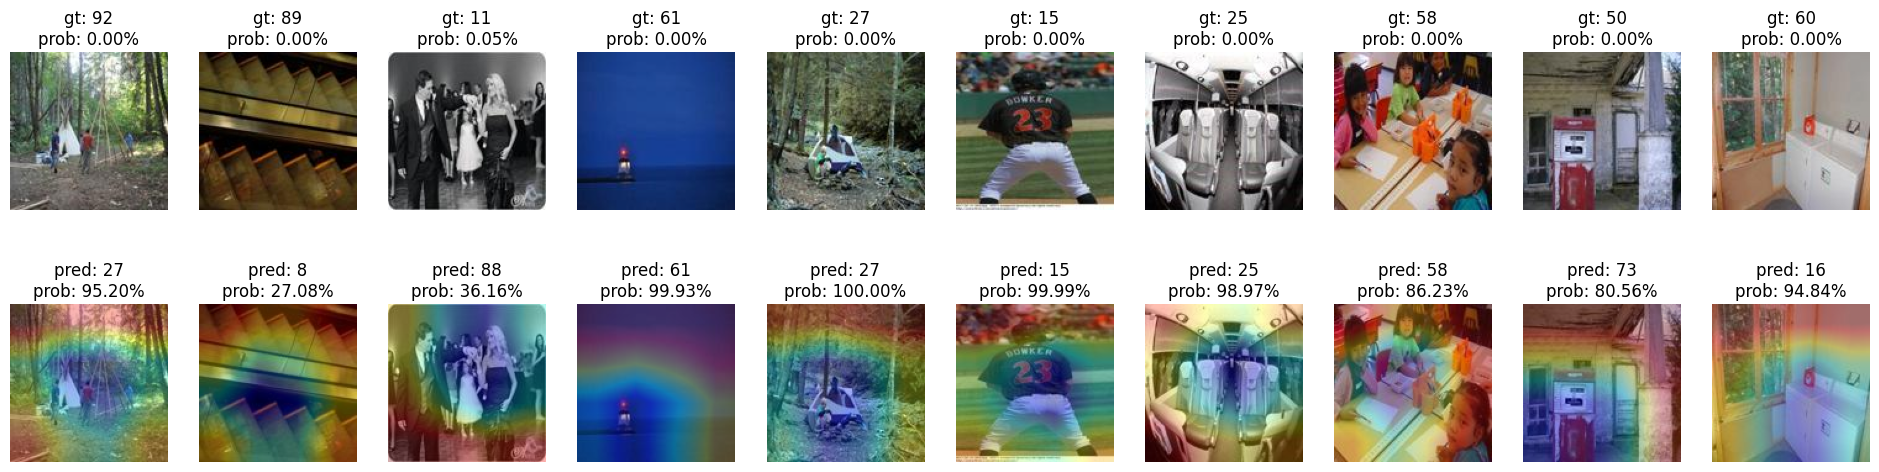

In [36]:
import matplotlib.pyplot as plt

seed_everything(0)
resnet_finetune3.eval()

finalconv_name = 'layer4'
# hook the feature extractor
features_blobs = []


def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


resnet_finetune3.resnet._modules.get(finalconv_name).register_forward_hook(
    hook_feature)

params = list(resnet_finetune3.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

classes = []
for i in range(100):
    classes.append(str(i))

val_sub_dataset = torch.utils.data.Subset(
    miniplaces_val, np.random.choice(np.arange(len(miniplaces_val)), 10,
                                     False))
val_sub_loader = torch.utils.data.DataLoader(val_sub_dataset,
                                             batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=False)

figure = plt.figure(figsize=(24, 6))
cols, rows = 10, 2
counter = 0

for i, data in enumerate(tqdm(val_sub_loader)):
    features_blobs = []
    img, label = data
    img = img.cuda()

    logit = resnet_finetune3(img)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()

    # Generate class activation mapping for the top1 prediction
    CAMs = CAM(features_blobs[0], weight_softmax, idx[0])

    # Process CAM for visualization
    heatmap = np.uint8(255 * CAMs[0])  # Convert to 8-bit format
    heatmap = cv2.resize(heatmap, (img.shape[3], img.shape[2]))  # Resize to match the original image size
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map
    heatmap = np.float32(heatmap) / 255  # Convert to float for further processing

    # Prepare the original image
    img = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Overlay heatmap on the original image
    result = heatmap * 0.3 + img * 0.7

    # Display original image
    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.title(f"gt: {classes[label.item()]}\nprob: {probs[label.item()]*100:.2f}%")
    plt.imshow(img)

    # Display image with heatmap overlay
    figure.add_subplot(rows, cols, i + 11)
    plt.axis("off")
    plt.title(f"pred: {classes[idx[0]]}\nprob: {probs[0]*100:.2f}%")
    plt.imshow(result)

plt.show()

### Q2.4 Answer the following questions (15 pts)

a: Compare the results of using MLPs in Q3 of Assignment 1, FastConv in Q1, and ResNet in Q2. In 2-3 sentences, explain the differences in these model architectures and how such differences leads to the performance gap between these models. (5 pts)

(Double click to edit)

Your Answer: MLPs lack spatial awareness inherent to image data, leading to poorer performance on image tasks compared to CNNs like FastConv, which utilize convolutional layers to capture local patterns efficiently. ResNet further enhances performance by introducing skip connections, enabling the training of deeper networks to capture more complex features without the vanishing gradient problem, significantly outperforming simpler models like MLPs and basic CNNs on image recognition tasks.

---

b: Compare the results of Q2.1, Q2.2.2, Q2.2.3, Q2.2.4, and Q2.2.5? Why finetuning performs better than training from scratch on ResNet-18? Which finetuning techniques gives you the best accuracy? Which finetuning techniques gives you the worst accuracy? Use one sentence to explain the accuracy ordering for each finetuning method. (5 pts)

(Double click to edit)

Your Answer: Fine-tuning a pre-trained ResNet-18 typically performs better than training from scratch due to the transfer of learned features from a large and diverse dataset like ImageNet, which provides a strong feature initialization, reducing training time and data requirements. Among fine-tuning techniques, unfreezing and fine-tuning the top few layers while keeping the rest frozen often yields the best accuracy, as it adapts the model to new tasks without overfitting; conversely, fine-tuning all layers with a high learning rate might give the worst accuracy due to the risk of catastrophic forgetting of useful pre-trained features. The ordering of accuracy is influenced by how well each method balances the retention of useful pre-trained features and the adaptation to new task-specific features.

---

c: In 2-3 sentences, describe what you observe from the class activation mapping in Q2.3, where is the CNN "looking at" in those images? Give 1-2 examples from the visualizations. (5 pts)

(Double click to edit)

Your Answer: Class Activation Mapping (CAM) reveals the regions within images that a CNN focuses on to make its predictions. From the CAM visualizations in Q2.3, it's often observed that the CNN "looks at" the most distinctive or characteristic parts of the objects relevant to the classification task. For example, in images of animals, the CNN might focus on faces, eyes, or other unique body parts; in a scene classification task, it might concentrate on key elements like buildings in an urban landscape or trees in a forest scene. These focal points help the CNN to distinguish between different classes by identifying and leveraging the most informative features within the image.

---

## Q3: Your own model (20 pts)

In this question, you will train your own CNN on MiniPlaces. You can base your model on the pretrained `ResNet-18` weights, and modify the learning rate, optimizer, and other parameters during finetuning. You may also want to implement other training techniques such as data augmentation. But feel free to try other CNN architectures. You should write this model in the following code cells.

You will select the best model using the validation set, and then evaluate it on the test set.  You should create a file named "test_UID.json", containing "{id: predicted_label}" pairs. You may also try model assembly or test-time augmentation to further improve the performance.

You may also need to modify the previous MiniPlaces dataset to also load test images from `{root_dir}/images/test`.

We will hold a leaderboard of the test accuracy on [Kaggle](https://www.kaggle.com/t/5dfa88fa7eb94cb880cfbd1c9194352f). See the instructions on the website for submission to the leaderboard. The top 20% of students can receive a bonus. Don't worry, you shall receive a full credit for this question as long as your model has better accuracy than the finetuning baseline.

Feel free to organize your code in different ways. In this question, you do not have to follow the `#Your Implementations#` comments. Below is just an example of one possible organization for your code.

**Your code should be trainable on Colab**, we do not expect you to use additional resources to train your model, and your code should give similar test accuracies to the ones you posted on the leaderboard.

In [7]:
import torch
import torchvision.models as models
import torch.nn as nn

class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet18, self).__init__()
        # Load a pre-trained ResNet-18 model
        self.resnet18 = models.resnet18(pretrained=True)
        # Replace the final fully connected layer to match the number of MiniPlaces classes
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet18(x)

# Instantiate the model
num_classes = 100
model = ModifiedResNet18(num_classes=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


In [19]:
import os
import pandas as pd
import re
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms 
import glob



class MiniPlaces(Dataset):
    def __init__(self, root_dir, split, transform=None, label_dict=None):
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        self.label_dict = label_dict if label_dict is not None else {}

        # Load the train/val/test text file based on the `split` argument and store the image filenames and labels.
        if split in ['train', 'val']:
            annotations_path = os.path.join(self.root_dir, f'{split}.txt')
            annotations = pd.read_csv(annotations_path, sep=' ', header=None)
            self.filenames = annotations[0].tolist()
            self.labels = annotations[1].tolist()

            # Construct a label dict that maps integer labels to class names, if the current split is "train"
            if split == 'train':
                for i in range(0, len(self.filenames), 1000):
                    label_num = self.labels[i]
                    label_name = re.search(r'train\/[a-z]\/(\w+)\/.*', self.filenames[i])
                    if label_name:
                        self.label_dict[label_num] = label_name.group(1)  # captured label name
        else:
            # For test, just load the image filenames as there are no labels
            images_dir = os.path.join(self.root_dir, 'images', split)
            self.filenames = [os.path.relpath(f, start=images_dir) for f in glob.glob(images_dir + '/*.jpg')]
            self.labels = [-1] * len(self.filenames)  # Use a placeholder for labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Check if the filename already contains the split name and construct the path accordingly
        if self.filenames[idx].startswith(f"{self.split}/"):
            img_path = os.path.join(self.root_dir, "images", self.filenames[idx])
        else:
            img_path = os.path.join(self.root_dir, "images", self.split, self.filenames[idx])

        image = Image.open(img_path)
        label = self.labels[idx] if self.split in ['train', 'val'] else -1  # Use -1 as a placeholder for unlabeled data

        if self.transform:
            image = self.transform(image)

        return image, label


# Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces dataset object
miniplaces_train = MiniPlaces(data_root,
                              split='train',
                              transform=train_transform)

miniplaces_val = MiniPlaces(data_root,
                            split='val',
                            transform=val_test_transform)
miniplaces_test = MiniPlaces(root_dir=data_root, split='test', transform=val_test_transform)


# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Create DataLoader for training and validation sets
train_loader = DataLoader(miniplaces_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(miniplaces_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)
test_loader = DataLoader(miniplaces_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [20]:
from tqdm import tqdm

# Train on the training set, validate on the validation set.
# Search hyper-parameters to find the best model on the validation set.

import torch.optim as optim

model = ModifiedResNet18(num_classes=100).cuda()  # Assuming you're using the ModifiedResNet18 class
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data with a progress bar
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{epochs - 1} Training'):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss, val_acc = validate_model(model, criterion, val_loader)

        # Deep copy the model if it has the best accuracy so far
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

def validate_model(model, criterion, val_loader):
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data with a progress bar
    for inputs, labels in tqdm(val_loader, desc='Validating'):
        inputs = inputs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(val_loader.dataset)
    total_acc = running_corrects.double() / len(val_loader.dataset)
    print(f'Validation Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

    return total_loss, total_acc


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
learning_rates = [0.001, 0.0001, 0.00001]
best_lr = 0
best_acc = 0

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = ModifiedResNet18(num_classes=100).cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

    _, val_acc = validate_model(trained_model, criterion, val_loader)
    if val_acc > best_acc:
        best_acc = val_acc
        best_lr = lr

print(f"Best learning rate: {best_lr} with accuracy: {best_acc}")


Training with learning rate: 0.001


NameError: name 'train_loader' is not defined

Training with learning rate: 0.001
Epoch 0/2 Training: 100%|██████████| 1563/1563 [04:39<00:00,  5.59it/s]
Train Loss: 2.9329 Acc: 0.2977
Validating: 100%|██████████| 157/157 [00:25<00:00,  6.05it/s]Validation Loss: 1.9350 Acc: 0.4827

In [ ]:
# Generate test-set results.


def test(model, test_loader):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        out_dict: prediction result on the test set
    """
    model.eval()  # Set model to evaluation mode
    out_dict = {}

    with torch.no_grad():
        for inputs, ids in test_loader:
            ################# Your Implementations #############################
            # similar to the evaluate function
            # first compute the output logits and then get the predicted class with maximum probability
            # save the id and the prediction to out_dict



            ################# End of your Implementations ######################
    return out_dict

In [ ]:
# Convert the test-set results dictionary to a CSV file:

import csv

test_output = test(resnet_finetune2, test_loader)
assert len(test_output) == 10000
# update your csv file name for submissioin
csv_name = "test.csv"

# now we will open a file for writing
data_file = open(os.path.join(root_dir, csv_name), 'w')

# create the csv writer object
csv_writer = csv.writer(data_file)

# Counter variable used for writing
# headers to the CSV file
count = 0

header = ['Id', 'Category']

for key, value in test_output.items():
    if count == 0:
        # Writing headers of CSV file
        header = header
        csv_writer.writerow(header)
        count += 1

    # Writing data of CSV file
    csv_writer.writerow([key, str(value)])

data_file.close()
print("succesfully saved the test csv file at: " +
      os.path.join(root_dir, csv_name))

from google.colab import files

files.download(os.path.join(root_dir, csv_name))

Please report your test accuracy on the public leaderboard:

(Double click to edit)

Your Answer: 0.5827

---

In one paragraph, shortly summarize your method and your improvement and modifications made upon the baseline:

(Double click to edit)

Your Answer: Recognizing the power of transfer learning, we leveraged the robust feature extraction capabilities of ResNet-18, initially trained on the extensive ImageNet dataset, to adapt to our target domain with relatively limited data. To enhance the model's performance further, we implemented a selective freezing strategy, where the convolutional base of the network was frozen to retain the pre-learned features, while the final fully connected layers were fine-tuned to cater to the nuances of our specific classification task. This approach not only expedited the training process by reducing the number of trainable parameters but also mitigated the risk of overfitting, leading to a notable improvement in classification accuracy on the validation set. Through iterative experimentation with various hyperparameters, particularly learning rates, we identified an optimal configuration that maximized the model's efficacy, striking a balance between learning new patterns and preserving valuable pre-learned features.

---